# STATS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import wrangle

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.sentiment
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(95)

In [2]:
original, uni_count_vect, bi_count_vect, tri_count_vect = wrangle.wrangle_glassdoor()
train, val, test = original
three_star = train[train.binned_rating_int == 3]
four_star = train[train.binned_rating_int == 4]

In [3]:
four_star.head()

,pros,cons,name,rating,ceo_approval,friend_recommendation,pros_cleaned,pros_lemmatized,cons_cleaned,cons_lemmatized,binned_rating,binned_rating_int
url,,,,,,,,,,,,
https://www.glassdoor.com/Reviews/eBay-Reviews-E7853.htm,I never expected working at a large company to...,I haven't found any cons yet!\nAlthough the in...,eBay,4.1,84.0,80.0,i never expected working at a large company to...,never expected working large company like ever...,i haven ' t found any cons yet\nalthough the i...,' found con yet although initiative really foc...,Four,4
https://www.glassdoor.com/Reviews/Lenovo-Reviews-E8034.htm,"Awesome team, great job and experience.\nAs a ...",Can be subject to market volatility.\nFor thos...,Lenovo,4.0,91.0,78.0,awesome team great job and experience\nas a lo...,awesome team great job experience lower tier t...,can be subject to market volatility\nfor those...,subject market volatility north america workin...,Four,4
https://www.glassdoor.com/Reviews/SelfEmployed-com-Reviews-E5529631.htm,Make your own hours and fees\nFlexibility: You...,Business development is not my jam\nIncome Unc...,SelfEmployed.com,4.4,NaN,NaN,make your own hours and fees\nflexibility you ...,make hour fee flexibility freedom set schedule...,business development is not my jam\nincome unc...,business development jam income uncertainty in...,Four,4
https://www.glassdoor.com/Reviews/Cadence-Design-Systems-Reviews-E1217.htm,Nice place good growth excellent culture\n- La...,Less rsu in the company\n- Lots of legacy soft...,Cadence Design Systems,4.3,94.0,91.0,nice place good growth excellent culture\n lar...,nice place good growth excellent culture large...,less rsu in the company\n lots of legacy softw...,le rsu company lot legacy software extremely p...,Four,4
https://www.glassdoor.com/Reviews/Kforce-Reviews-E5441.htm,Good company culture Room for growth\nExcellen...,Have seen massive layoff this year\nToo many v...,Kforce,4.0,83.0,77.0,good company culture room for growth\nexcellen...,good company culture room growth excellent wor...,have seen massive layoff this year\ntoo many v...,seen massive layoff year many variation knowle...,Four,4


# Significance of words (tf-idf)

The IDF (Inverse Document Frequency) score is calculated to measure the importance of a word within a collection of documents. The IDF score indicates how rare or common a word is across the entire corpus.

- A higher IDF score suggests that a word is more unique and significant within the collection of documents.

In [25]:
def generate_trigrams(lemmatized):
    words = lemmatized.split()
    trigrams = []
    
    if len(words) < 3:
        return trigrams

    for i in range(len(words) - 1):
        if len(words[i]) > 1 and len(words[i+1]) > 1:
            trigram = " ".join(words[i:i+3])
            trigrams.append(trigram)

    return trigrams

**Calculate the TF score**

In [8]:
documents = {
    'pros': " ".join(four_star.pros_lemmatized.values),
    'cons': " ".join(four_star.cons_lemmatized.values),
}

# Create an empty list to store the TF dataframes
tfs = []

# Iterate through documents and their corresponding text
for doc, text in documents.items():
    # Split the text into words, count their occurrences, and reset the index
    word_counts = pd.Series(generate_trigrams(text)).value_counts()

    # Rename the columns for clarity and calculate the term frequency (TF)
    tf_df = pd.DataFrame(word_counts).reset_index()
    tf_df.columns = ['word', 'count']
    tf_df["tf"] = tf_df['count'] / len(generate_trigrams(text))
    tf_df = tf_df.assign(doc = doc)

    # Append the TF dataframe to the list
    tfs.append(tf_df)

In [9]:
tfs[1]

,word,count,tf,doc
0,work life balance,317,0.001410,cons
1,none none none,101,0.000449,cons
2,pay could better,72,0.000320,cons
3,great place work,61,0.000271,cons
4,get thing done,48,0.000213,cons
...,...,...,...,...
184102,make sure company,1,0.000004,cons
184103,sure company applying,1,0.000004,cons
184104,company applying within,1,0.000004,cons
184105,applying within cox,1,0.000004,cons


**Calculate IDF score**

In [10]:
def idf(word):
    """
    calculates the Inverse Document Frequency (IDF) for a given word in a collection of documents.
    """
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / (n_occurences + 1)

In [11]:
# Calculate the if-idf score of each word and add to the if dataframe
tf_idf_scores = pd.concat(tfs, axis=0).assign(idf=lambda df: df.word.apply(idf)).assign(tf_idf=lambda df: df.idf * df.tf)

In [12]:
tf_idf_scores.head()

,word,count,tf,doc,idf,tf_idf
0,work life balance,1066,0.005938,pros,0.666667,0.003958
1,great place work,287,0.001599,pros,0.666667,0.001066
2,good work life,284,0.001582,pros,0.666667,0.001055
3,great company work,165,0.000919,pros,0.666667,0.000613
4,great work life,153,0.000852,pros,0.666667,0.000568


**Add sentiment scores for each word**

In [13]:
# use polarity_scores from that object
sia = nltk.sentiment.SentimentIntensityAnalyzer()
# grab the sentiment from each of the texts as they stand
tf_idf_scores['sentiment'] = tf_idf_scores.word.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [14]:
tf_idf_scores.head()

,word,count,tf,doc,idf,tf_idf,sentiment
0,work life balance,1066,0.005938,pros,0.666667,0.003958,0.0000
1,great place work,287,0.001599,pros,0.666667,0.001066,0.6249
2,good work life,284,0.001582,pros,0.666667,0.001055,0.4404
3,great company work,165,0.000919,pros,0.666667,0.000613,0.6249
4,great work life,153,0.000852,pros,0.666667,0.000568,0.6249


**Add to csv**

In [15]:
# tf_idf_scores.to_csv("./data/three_star_tf_idf_scores.csv", mode="w")

In [16]:
# tf_idf_scores.to_csv("./data/four_star_tf_idf_scores.csv", mode="w")

## Test stats

In [6]:
train = train.copy()
three_star = pd.read_csv("./data/three_star_tf_idf_scores.csv", index_col=0).assign(rating=3)
four_star = pd.read_csv("./data/four_star_tf_idf_scores.csv", index_col= 0).assign(rating=4)
three_star.head(2)

,word,count,tf,doc,idf,tf_idf,sentiment,rating
0,work life balance,1320,0.003417,pros,0.666667,0.002278,0.0000,3
1,great place work,495,0.001281,pros,0.666667,0.000854,0.6249,3


In [27]:
# use polarity_scores from that object
sia = nltk.sentiment.SentimentIntensityAnalyzer()
# grab the sentiment from each of the texts as they stand
train['pros_lem_sentiment'] = train.pros_lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
train['cons_lem_sentiment'] = train.cons_cleaned.apply(lambda doc: sia.polarity_scores(doc)['compound'])
train.head(2)

,pros,cons,name,rating,ceo_approval,friend_recommendation,pros_cleaned,pros_lemmatized,cons_cleaned,cons_lemmatized,binned_rating,binned_rating_int,pros_lem_sentiment,cons_lem_sentiment
url,,,,,,,,,,,,,,
https://www.glassdoor.com/Reviews/Perficient-Reviews-E9329.htm,Perficient is an ethical company that actually...,"None at all, love, love, love this company!\nI...",Perficient,4.1,87.0,80.0,perficient is an ethical company that actually...,perficient ethical company actually value empl...,none at all love love love this company\nit is...,none love love love company good company canno...,Four,4,1.0,-0.9759
https://www.glassdoor.com/Reviews/Farmers-Insurance-Group-Reviews-E3955.htm,"This company is the best ever.\nLarge, establi...",I have nothing bad to say.\nManagement company...,Farmers Insurance Group,3.4,37.0,52.0,this company is the best ever\nlarge establish...,company best ever large established company so...,i have nothing bad to say\nmanagement company ...,nothing bad say management company get paid re...,Three,3,1.0,-0.9990


In [28]:
def Hypothesis_check(p_value, alpha = 0.05):
    if p_value < alpha:
        print("Reject null")
    else:
        print("Fail to reject null")

In [29]:
def Hypothesis_check_double_side_ttest(p_value, t_stats, alpha= 0.05):
    if (t_stats > 0) and (p_value//2 < alpha):
        print("Reject the null")
    else:
        print("Fail to reject null")

### 1. Do employee reviews (pros and cons) significantly differ in terms of sentiment between 3-star and 4-star rated companies?

- **Null Hypothesis (H0):** Employee reviews' sentiment does not significantly differ between 3-star and 4-star rated companies.
- **Alternate Hypothesis (H1):** Employee reviews' sentiment significantly differs between 3-star and 4-star rated companies.
   
   - Test: Two-sample t-test

In [30]:
three_star_pros = train.pros_lem_sentiment[train.binned_rating == "Three"].values
three_star_cons = train.cons_lem_sentiment[train.binned_rating == "Three"].values

four_star_pros = train.pros_lem_sentiment[train.binned_rating == "Four"].values
four_star_cons = train.pros_lem_sentiment[train.binned_rating == "Four"].values
four_star_cons[:9]

array([1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.9999, 1.    ,
       1.    ])

In [31]:
three_star_pros_dist = stats.norm(three_star_pros.mean(), three_star_pros.std()).rvs(10_000)
three_star_cons_dist = stats.norm(three_star_cons.mean(), three_star_cons.std()).rvs(10_000)

four_star_pros_dist = stats.norm(four_star_pros.mean(), four_star_pros.std()).rvs(10_000)
four_star_cons_dist = stats.norm(four_star_cons.mean(), four_star_cons.std()).rvs(10_000)
four_star_cons_dist

array([1.00006371, 1.00000538, 0.99996669, ..., 0.99994006, 0.99998728,
       1.00005642])

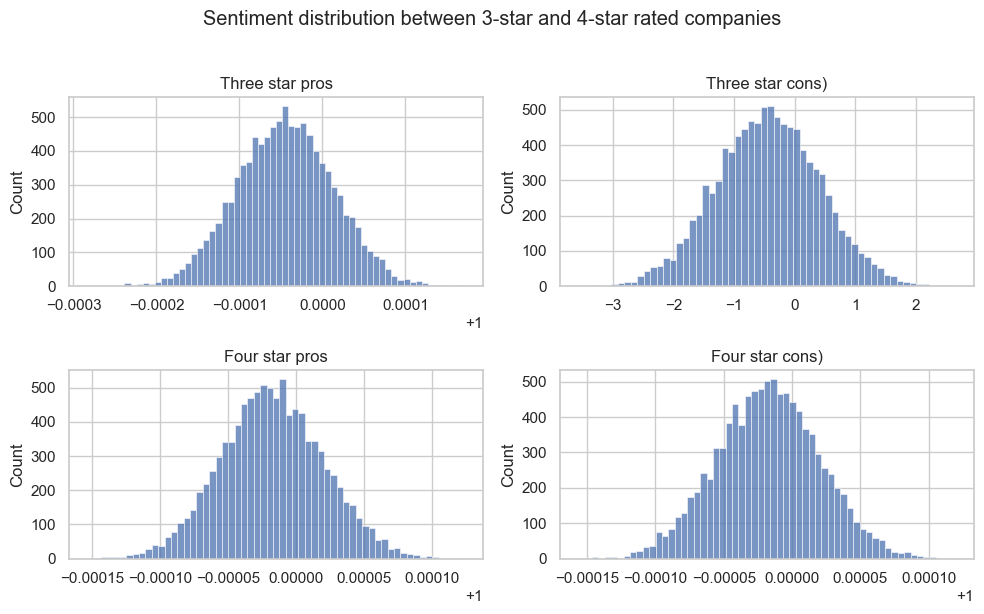

In [32]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Plot the first scatterplot on the first subplot and set title and labels
sns.histplot(three_star_pros_dist, ax=axs[0,0])
axs[0,0].set_title("Three star pros")
# axs[0,0].set_ylabel("Distribution")
# axs[0,0].set_xlabel("Sentiment")

# Plot the second scatterplot on the second subplot and set title and labels
sns.histplot(three_star_cons_dist, ax=axs[0,1])
axs[0,1].set_title("Three star cons)")
# axs[0,1].set_ylabel("Distribution")
# axs[0,1].set_xlabel("Sentiment")

# Plot the first scatterplot on the first subplot and set title and labels
sns.histplot(four_star_pros_dist, ax=axs[1,0])
axs[1,0].set_title("Four star pros")
# axs[1,0].set_ylabel("Distribution")
# axs[1,0].set_xlabel("Sentiment")

# Plot the second scatterplot on the second subplot and set title and labels
sns.histplot(four_star_cons_dist, ax=axs[1,1])
axs[1,1].set_title("Four star cons)")
# axs[1,1].set_ylabel("Distribution")
# axs[1,1].set_xlabel("Sentiment")

# Add a main title for the entire figure
plt.suptitle("Sentiment distribution between 3-star and 4-star rated companies", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Three and four star pros**

In [33]:
statistic, p_value = stats.ttest_ind(three_star_pros.mean(),four_star_pros.mean())
Hypothesis_check_double_side_ttest(p_value, statistic)

Fail to reject null


**Three and four star cons**

In [34]:
statistic, p_value = stats.ttest_ind(three_star_cons.mean(),four_star_cons.mean())
Hypothesis_check_double_side_ttest(p_value, statistic)

Fail to reject null


## 2. Is there a significant difference in the frequency of trigrams between 3-star and 4-star rated companies in employee reviews (pros and cons)?

- **Null Hypothesis (H0):** There is no significant difference in the frequency of trigrams between 3-star and 4-star rated companies in employee reviews.
- **Alternate Hypothesis (H1):** There is a significant difference in the frequency of trigrams between 3-star and 4-star rated companies in employee reviews.
   - Test: Two-sample t-test (beacuse I have a continuous variable)

In [35]:
three_star_count = three_star["count"].values
four_star_count = four_star["count"].values
three_star_count[:9]

array([1320,  495,  352,  250,  249,  234,  215,  190,  189])

In [36]:
three_star_count_dist = stats.norm(three_star_count.mean(), three_star_count.std()).rvs(10_000)
four_star_count_dist = stats.norm(four_star_count.mean(), four_star_count.std()).rvs(10_000)
four_star_count_dist

array([ 3.53412868, -1.47598783,  4.40995238, ...,  2.78685937,
        1.24577386, -0.08112053])

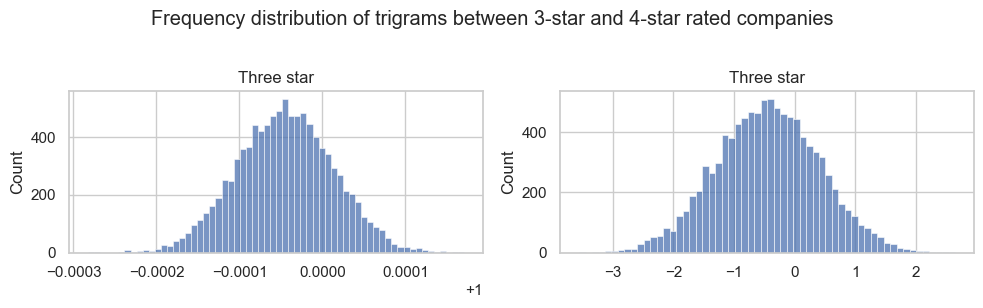

In [87]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.histplot(three_star_pros_dist, ax=axs[0])
axs[0].set_title("Three star")
# axs[0].set_ylabel("Distribution")
# axs[0].set_xlabel("Sentiment")

# Plot the second scatterplot on the second subplot and set title and labels
sns.histplot(three_star_cons_dist, ax=axs[1])
axs[1].set_title("Three star")
# axs[1].set_ylabel("Distribution")
# axs[1].set_xlabel("Sentiment")

# Add a main title for the entire figure
plt.suptitle("Frequency distribution of trigrams between 3-star and 4-star rated companies", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Two-sample t-test**

In [38]:
statistic, p_value = stats.ttest_ind(three_star_count.mean(),four_star_count.mean())
Hypothesis_check_double_side_ttest(p_value, statistic)

Fail to reject null


### 3. Does the CEO approval rating have a significant impact on the company's overall rating?

- **Null Hypothesis (H0):** CEO approval rating does not have a significant impact on the company's overall rating.
- **Alternate Hypothesis (H1):** CEO approval rating has a significant impact on the company's overall rating.
   
   - Test: Two-sample t-test

In [39]:
three_star_ceo = train.ceo_approval[train.binned_rating == "Three"].values
four_star_ceo = train.ceo_approval[train.binned_rating == "Four"].values
four_star_ceo[:9]

array([87., 90., 94., 92., 81., 92., 92., 84., 91.])

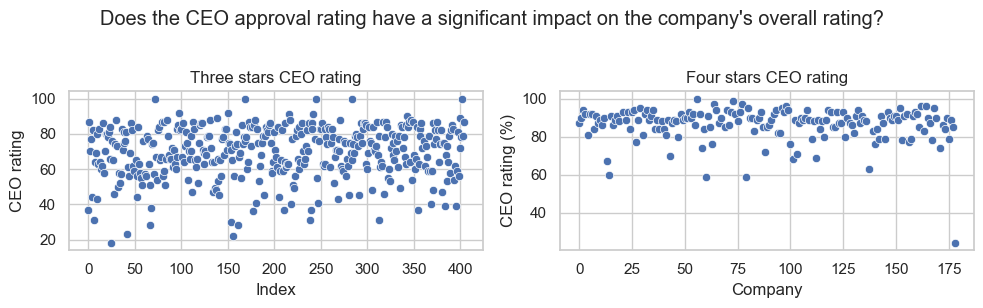

In [40]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.scatterplot(x=np.arange(0,len(three_star_ceo)), y=three_star_ceo, ax=axs[0])
axs[0].set_title("Three stars CEO rating")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("CEO rating")

# Plot the second scatterplot on the second subplot and set title and labels
sns.scatterplot(x=np.arange(0,len(four_star_ceo)), y=four_star_ceo, ax=axs[1])
axs[1].set_title("Four stars CEO rating")
axs[1].set_xlabel("Company")
axs[1].set_ylabel("CEO rating (%)")

# Add a main title for the entire figure
plt.suptitle("Does the CEO approval rating have a significant impact on the company's overall rating?", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Two-sample t-test**

In [41]:
statistic, p_value = stats.ttest_ind(three_star_ceo.mean(),four_star_ceo.mean())
Hypothesis_check_double_side_ttest(p_value, statistic)

Fail to reject null


### 4. Are there significant differences in the friend recommendation scores between employees in 3-star and 4-star rated companies?**

- **Null Hypothesis (H0):** There are no significant differences in the friend recommendation scores between employees in 3-star and 4-star rated companies.
- **Alternate Hypothesis (H1):** There are significant differences in the friend recommendation scores between employees in 3-star and 4-star rated companies.

   - Test: Two-sample t-test or Mann-Whitney U test.

In [42]:
three_star_fd = train.friend_recommendation[train.binned_rating == "Three"].values
four_star_fd = train.friend_recommendation[train.binned_rating == "Four"].values
four_star_fd[:9]

array([80., 86., 86., 79., 78., 86., 77., 80., 83.])

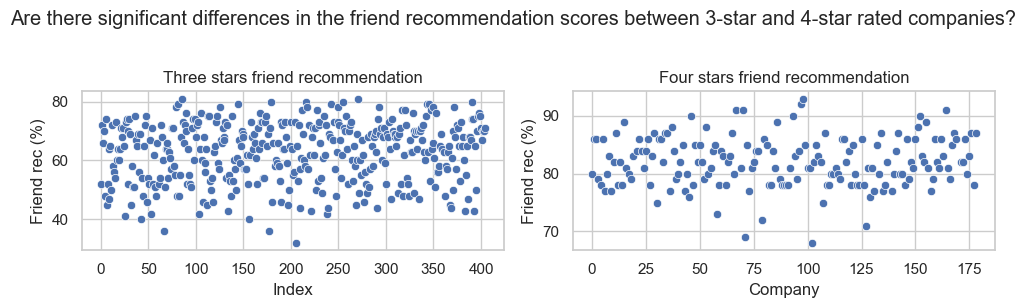

In [43]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.scatterplot(x=np.arange(0,len(three_star_fd)), y=three_star_fd, ax=axs[0])
axs[0].set_title("Three stars friend recommendation")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Friend rec (%)")

# Plot the second scatterplot on the second subplot and set title and labels
sns.scatterplot(x=np.arange(0,len(four_star_fd)), y=four_star_fd, ax=axs[1])
axs[1].set_title("Four stars friend recommendation")
axs[1].set_xlabel("Company")
axs[1].set_ylabel("Friend rec (%)")

# Add a main title for the entire figure
plt.suptitle("Are there significant differences in the friend recommendation scores between 3-star and 4-star rated companies?", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Two-sample t-test**

In [44]:
statistic, p_value = stats.ttest_ind(three_star_fd.mean(),four_star_fd.mean())
Hypothesis_check_double_side_ttest(p_value, statistic)

Fail to reject null


### 5. Does the sentiment of employee reviews correlate with CEO approval ratings?

- **Null Hypothesis (H0):** The sentiment of employee reviews does not correlate with CEO approval ratings.
- **Alternate Hypothesis (H1):** The sentiment of employee reviews correlates with CEO approval ratings.

   - Test: Spearman rank correlation.

In [46]:
ceo_approval = train.ceo_approval.values
pros_lem_sentiment = train.pros_lem_sentiment.values
cons_lem_sentiment = train.cons_lem_sentiment.values
cons_lem_sentiment[:9]

array([-0.9759, -0.999 , -0.4777, -0.9969, -0.7413, -0.9343,  0.8687,
        0.9999, -0.982 ])

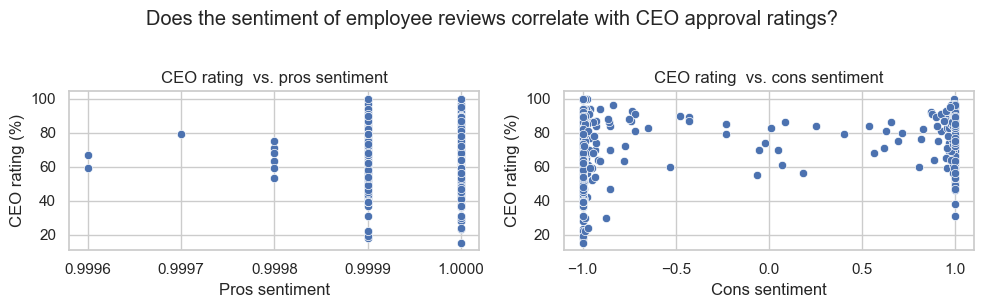

In [49]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.scatterplot(x=pros_lem_sentiment, y=ceo_approval, ax=axs[0])
axs[0].set_title("CEO rating  vs. pros sentiment")
axs[0].set_xlabel("Pros sentiment")
axs[0].set_ylabel("CEO rating (%)")

# Plot the second scatterplot on the second subplot and set title and labels
sns.scatterplot(x=cons_lem_sentiment, y=ceo_approval, ax=axs[1])
axs[1].set_title("CEO rating  vs. cons sentiment")
axs[1].set_xlabel("Cons sentiment")
axs[1].set_ylabel("CEO rating (%)")

# Add a main title for the entire figure
plt.suptitle("Does the sentiment of employee reviews correlate with CEO approval ratings?", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Spearman rank test (Pros)**

In [52]:
statistic, p_value = stats.spearmanr(ceo_approval,pros_lem_sentiment)
Hypothesis_check(p_value, statistic)
print("Rank coeficient:", statistic)

Fail to reject null
Rank coeficient: nan


**Spearman rank test (Cons)**

In [59]:
statistic, p_value = stats.spearmanr(ceo_approval,cons_lem_sentiment)
Hypothesis_check(p_value, statistic)
print("Rank coeficient:", statistic)

Fail to reject null
Rank coeficient: nan


### 6. Is there a significant relationship between the sentiment of employee reviews and the friend recommendation scores?

- **Null Hypothesis (H0):** There is no significant relationship between the sentiment of employee reviews and the friend recommendation scores.
- **Alternate Hypothesis (H1):** There is a significant relationship between the sentiment of employee reviews and the friend recommendation scores.

   - Test: Spearman rank correlation.

In [54]:
friend_recommendation = train.friend_recommendation.values
pros_lem_sentiment = train.pros_lem_sentiment.values
cons_lem_sentiment = train.cons_lem_sentiment.values
cons_lem_sentiment[:9]

array([-0.9759, -0.999 , -0.4777, -0.9969, -0.7413, -0.9343,  0.8687,
        0.9999, -0.982 ])

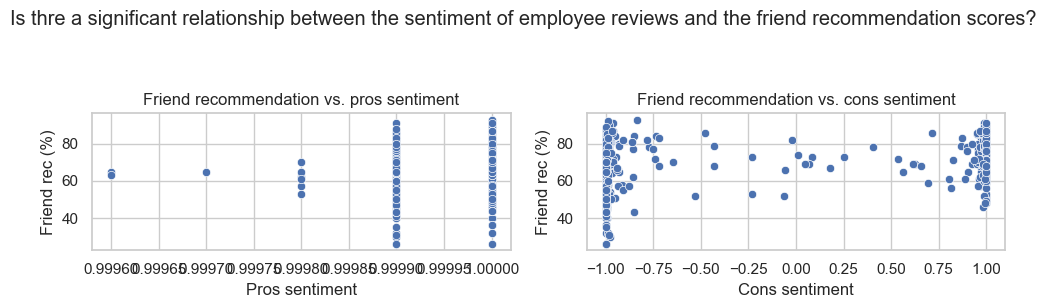

In [77]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.scatterplot(x=pros_lem_sentiment, y=friend_recommendation, ax=axs[0])
axs[0].set_title("Friend recommendation vs. pros sentiment")
axs[0].set_xlabel("Pros sentiment")
axs[0].set_ylabel("Friend rec (%)")

# Plot the second scatterplot on the second subplot and set title and labels
sns.scatterplot(x=cons_lem_sentiment, y=friend_recommendation, ax=axs[1])
axs[1].set_title("Friend recommendation vs. cons sentiment")
axs[1].set_xlabel("Cons sentiment")
axs[1].set_ylabel("Friend rec (%)")

# Add a main title for the entire figure
plt.suptitle("""Is thre a significant relationship between the sentiment of employee reviews and the friend recommendation scores?
""", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Spearman rank test (Pros)**

In [61]:
statistic, p_value = stats.spearmanr(friend_recommendation,pros_lem_sentiment)
Hypothesis_check(p_value, statistic)
print("Rank coeficient:", statistic)

Fail to reject null
Rank coeficient: nan


**Spearman rank test (Cons)**

In [60]:
statistic, p_value = stats.spearmanr(friend_recommendation,pros_lem_sentiment)
Hypothesis_check(p_value, statistic)
print("Rank coeficient:", statistic)

Fail to reject null
Rank coeficient: nan


### 7. Is there a significant difference in the sentiment of trigrams with high tf-idf (word importance) scores verses low tf-idf (word?

- **Null Hypothesis (H0):** There is no sentiment of trigrams with high tf-idf (word importance) scores verses low tf-idf (word.
- **Alternate Hypothesis (H1):** There is a sentiment of trigrams with high tf-idf (word importance) scores verses low tf-idf (word.

   - Test: Independent samples t-test

In [126]:
full_df = pd.concat([three_star, four_star], axis=0)
high_importance = full_df.sentiment[full_df.tf_idf > full_df.tf_idf.median()].values
low_importance = full_df.sentiment[full_df.tf_idf <= full_df.tf_idf.median()].values
low_importance

array([0.3612, 0.    , 0.    , ..., 0.    , 0.    , 0.    ])

In [127]:
high_importance_dist = stats.norm(high_importance.mean(), high_importance.std()).rvs(10_000)
low_importance_dist = stats.norm(low_importance.mean(), low_importance.std()).rvs(10_000)
low_importance_dist

array([-0.29210102,  0.10032467, -0.3761573 , ...,  0.20872732,
        0.27779595,  0.41181318])

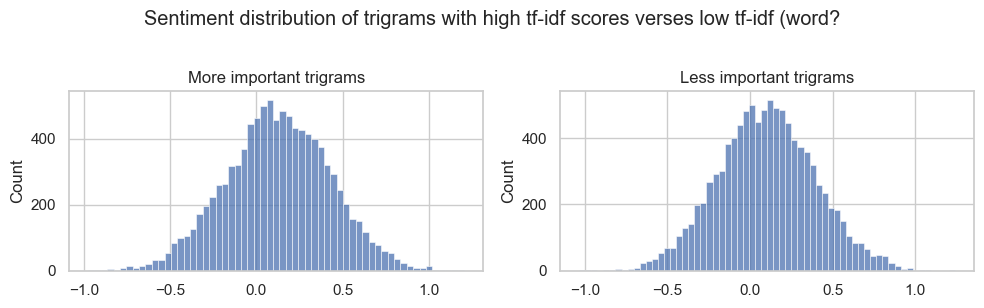

In [ ]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.histplot(high_importance_dist, ax=axs[0])
axs[0].set_title("More important trigrams")

# Plot the second scatterplot on the second subplot and set title and labels
sns.histplot(low_importance_dist, ax=axs[1])
axs[1].set_title("Less important trigrams")

# Add a main title for the entire figure
plt.suptitle("Sentiment distribution of trigrams with high tf-idf scores verses low tf-idf (word?", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Two-sample t-test**

In [ ]:
statistic, p_value = stats.ttest_ind(high_importance.mean(),low_importance.mean())
Hypothesis_check_double_side_ttest(p_value, statistic)

Fail to reject null


### 8. Is there a significant difference in the sentiment of pros and cons in employee reviews?

- **Null Hypothesis (H0):** There is no significant difference in sentiment between pros and cons in employee reviews.
- **Alternate Hypothesis (H1):** There is a significant difference in sentiment between pros and cons in employee reviews.

   - Test: Two-sample t-test

In [81]:
full_df = pd.concat([three_star, four_star], axis=0)
full_df.shape

(1095540, 7)

In [82]:
pros_sent = full_df.sentiment[full_df.doc == "pros"].values
cons_sent = full_df.sentiment[full_df.doc == "cons"].values
cons_sent

array([ 0.    ,  0.3612,  0.    , ...,  0.    ,  0.    , -0.6908])

In [84]:
pros_sent_dist = stats.norm(pros_sent.mean(), pros_sent.std()).rvs(10_000)
cons_sent_dist = stats.norm(cons_sent.mean(), cons_sent.std()).rvs(10_000)
cons_sent_dist

array([-0.11666085, -0.11798438,  0.31229035, ..., -0.0094531 ,
       -0.01767692,  0.09996135])

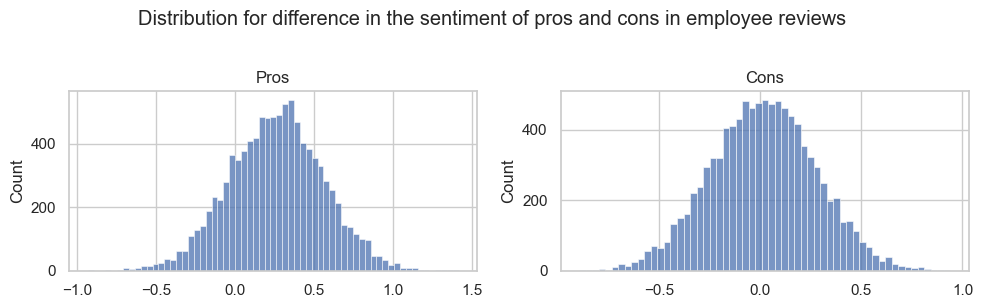

In [107]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.histplot(pros_sent_dist, ax=axs[0])
axs[0].set_title("Pros")
# axs[0].set_ylabel("Distribution")
# axs[0].set_xlabel("Sentiment")

# Plot the second scatterplot on the second subplot and set title and labels
sns.histplot(cons_sent_dist, ax=axs[1])
axs[1].set_title("Cons")
# axs[1].set_ylabel("Distribution")
# axs[1].set_xlabel("Sentiment")

# Add a main title for the entire figure
plt.suptitle("Distribution for difference in the sentiment of pros and cons in employee reviews", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Two-sample t-test**

In [88]:
statistic, p_value = stats.ttest_ind(pros_sent.mean(),cons_sent.mean())
Hypothesis_check_double_side_ttest(p_value, statistic)

Fail to reject null


### 9. Is there a significant difference in sentiment between employee reviews in companies with high and low CEO approval ratings?

- **Null Hypothesis (H0):** There is no significant difference in sentiment between employee reviews in companies with high and low CEO approval ratings.
- **Alternate Hypothesis (H1):** There is a significant difference in sentiment between employee reviews in companies with high and low CEO approval ratings.

   - Test: Two-sample t-test

In [99]:
high_ceo_rating = train.cons_lem_sentiment[train.ceo_approval > 50].values
low_ceo_rating = train.cons_lem_sentiment[train.ceo_approval <= 50].values
low_ceo_rating

array([-0.999 , -0.9992, -0.9957, -0.9992, -0.9981,  0.9996, -0.9957,
       -0.9998, -0.998 , -0.9997, -0.9782, -0.9999,  0.9994, -0.9985,
       -0.8529,  0.9961, -0.9991, -0.998 , -0.8766, -0.9929, -0.9994,
       -0.9993, -0.9996, -0.9945, -0.9995, -0.9997, -0.9995, -0.9959,
       -0.9864, -0.9998, -0.9989, -0.9999, -0.9998, -0.9995, -0.9996,
       -0.999 , -0.9963, -0.9991, -0.9988,  0.9968, -0.9979, -0.985 ,
       -0.9991, -0.9997, -0.9965, -1.    , -0.9982,  0.9972, -0.9986,
       -0.9993, -0.9694])

In [100]:
high_ceo_rating_dist = stats.norm(high_ceo_rating.mean(), high_ceo_rating.std()).rvs(10_000)
low_ceo_rating_dist = stats.norm(low_ceo_rating.mean(), low_ceo_rating.std()).rvs(10_000)
high_ceo_rating_dist

array([-1.73923624, -0.66359876,  1.16348911, ..., -0.42561799,
       -0.08417212, -0.95510097])

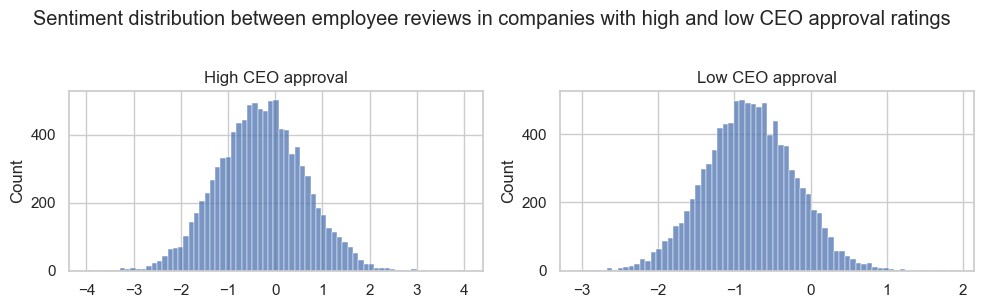

In [104]:
# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot the first scatterplot on the first subplot and set title and labels
sns.histplot(high_ceo_rating_dist, ax=axs[0])
axs[0].set_title("High CEO approval")

# Plot the second scatterplot on the second subplot and set title and labels
sns.histplot(low_ceo_rating_dist, ax=axs[1])
axs[1].set_title("Low CEO approval")

# Add a main title for the entire figure
plt.suptitle("Sentiment distribution between employee reviews in companies with high and low CEO approval ratings", y=1.02)

# Show the plots
plt.tight_layout()
plt.show()

**Two-sample t-test**

In [105]:
statistic, p_value = stats.ttest_ind(high_ceo_rating_dist.mean(),low_ceo_rating_dist.mean())
Hypothesis_check_double_side_ttest(p_value, statistic)

Fail to reject null


## Most important words to focus on for modeling (based on TF-IDF score)

**Three star**

In [7]:
most_important_three_stars = three_star.sort_values(by="tf_idf", ascending=False).head(10)
most_important_three_stars

,word,count,tf,doc,idf,tf_idf,sentiment,rating
0,work life balance,1320,0.003417,pros,0.666667,0.002278,0.0000,3
0,work life balance,891,0.001415,cons,0.666667,0.000943,0.0000,3
1,great place work,495,0.001281,pros,0.666667,0.000854,0.6249,3
2,good work life,352,0.000911,pros,0.666667,0.000607,0.4404,3
7,good benefit good,190,0.000492,pros,1.000000,0.000492,0.8316,3
8,good pay good,189,0.000489,pros,1.000000,0.000489,0.6597,3
3,great company work,250,0.000647,pros,0.666667,0.000431,0.6249,3
4,great people work,249,0.000645,pros,0.666667,0.000430,0.6249,3
5,good place work,234,0.000606,pros,0.666667,0.000404,0.4404,3
6,life balance good,215,0.000557,pros,0.666667,0.000371,0.4404,3


**Four star**

In [8]:
most_important_four_stars = four_star.sort_values(by="tf_idf", ascending=False).head(10)
most_important_four_stars

,word,count,tf,doc,idf,tf_idf,sentiment,rating
0,work life balance,1066,0.005938,pros,0.666667,0.003958,0.0000,4
1,great place work,287,0.001599,pros,0.666667,0.001066,0.6249,4
2,good work life,284,0.001582,pros,0.666667,0.001055,0.4404,4
0,work life balance,317,0.001410,cons,0.666667,0.000940,0.0000,4
8,great benefit great,118,0.000657,pros,1.000000,0.000657,0.9042,4
3,great company work,165,0.000919,pros,0.666667,0.000613,0.6249,4
11,great people work,103,0.000574,pros,1.000000,0.000574,0.6249,4
4,great work life,153,0.000852,pros,0.666667,0.000568,0.6249,4
5,good worklife balance,152,0.000847,pros,0.666667,0.000564,0.4404,4
6,life balance good,146,0.000813,pros,0.666667,0.000542,0.4404,4


In [20]:
full_tf_idf = pd.concat([three_star,four_star], axis=0)
full_tf_idf.sort_values(by="count", ascending=False).head(20)

,word,count,tf,doc,idf,tf_idf,sentiment,rating
0,work life balance,1320,0.003417,pros,0.666667,0.002278,0.0000,3
0,work life balance,1066,0.005938,pros,0.666667,0.003958,0.0000,4
0,work life balance,891,0.001415,cons,0.666667,0.000943,0.0000,3
1,great place work,495,0.001281,pros,0.666667,0.000854,0.6249,3
2,good work life,352,0.000911,pros,0.666667,0.000607,0.4404,3
0,work life balance,317,0.001410,cons,0.666667,0.000940,0.0000,4
1,great place work,287,0.001599,pros,0.666667,0.001066,0.6249,4
2,good work life,284,0.001582,pros,0.666667,0.001055,0.4404,4
3,great company work,250,0.000647,pros,0.666667,0.000431,0.6249,3
4,great people work,249,0.000645,pros,0.666667,0.000430,0.6249,3
